In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import re
import os

from result_utils import *

### Common function

In [7]:
handover_type = 'CU-1'
sim_duration = 30
results_dir = '../results/'
satellites_num = 76
AS = [[1, satellites_num + 49]]
gw_indices = [x for x in range(satellites_num + 1, satellites_num + 6)]
cell_indices = [x for x in range(satellites_num + 6, satellites_num + 50)]

topo_dir = './starlink-76-49-550-53-grid-LeastDelay'
change_file = topo_dir + '/Topo_leo_change.txt'

# assignments configuration
assignments = np.genfromtxt('./sim_configs/small_scenario/cell_assignment.csv', delimiter=',', dtype=int)
# assignments_time = assignments_df[:, 0]
# assignments = assignments_df[:, 1:].astype(int)

# user demands
# demands_df = np.genfromtxt('./sim_configs/user_demand.csv', delimiter=',', skip_header=1)
# demands_time = demands_df[:, 0]
# demands = demands_df[:, 1:]

demands = np.ones((assignments.shape[0]))*20e6

change_matrix, change_time = construct_change_matrix(len(cell_indices), change_file, cell_indices, sim_duration)

Time: 2:
Add link: 49 99
Add link: 39 109
Add link: 55 120
Add link: 39 124
Del link: 44 99
Del link: 32 109
Del link: 19 120
Del link: 32 124
Time: 3:
Add link: 39 82
Add link: 49 118
Del link: 32 82
Del link: 44 118
Time: 4:
Add link: 69 82
Add link: 76 83
Add link: 45 89
Add link: 69 90
Add link: 76 91
Add link: 66 94
Add link: 69 95
Add link: 69 96
Add link: 49 102
Add link: 76 103
Add link: 49 107
Add link: 69 108
Add link: 69 109
Add link: 76 111
Add link: 42 115
Add link: 76 117
Add link: 42 119
Add link: 49 123
Add link: 69 124
Del link: 39 82
Del link: 45 83
Del link: 62 89
Del link: 32 90
Del link: 45 91
Del link: 45 94
Del link: 32 95
Del link: 32 96
Del link: 44 102
Del link: 45 103
Del link: 44 107
Del link: 32 108
Del link: 39 109
Del link: 45 111
Del link: 37 115
Del link: 45 117
Del link: 37 119
Del link: 44 123
Del link: 39 124
Time: 5:
Add link: 49 88
Add link: 76 89
Add link: 72 99
Add link: 49 101
Add link: 72 107
Add link: 69 110
Add link: 76 112
Add link: 42 114
A

## Throughput

In [19]:
# Load the data
total_transfer = 0
total_transfer_per_cell = []

total_demands_per_cell = []
total_demands = 0

for cell in cell_indices:
    perf_file = results_dir + 'gw_5_fix_demands/iperf/iperf_' + str(cell) + '_results.txt'
    sections = extract_perf_sections(perf_file)
    if sections is None:
        continue
    transferred_list, trans_rates_list = parse_perf_results(sections)
    print ("cell: {}".format(cell))
    print (len(transferred_list))
    print (len(trans_rates_list))
    transferred_list = handover_through_time(cell, gw_indices[assignments[cell_indices.index(cell)]],
                                             change_matrix, change_time, cell_indices, transferred_list,
                                             trans_rates_list, handover_type, topo_dir)
            
            
    transferred = aggregate_results(transferred_list)
    total_transfer_per_cell.append(transferred)

total_transfer = sum(total_transfer_per_cell)

total_demands_per_cell = demands * 56
total_demands = sum(total_demands_per_cell)

cell: 82
56
48
len: 28
cell: 83
56
22
len: 28


IndexError: list index out of range

In [48]:
print ("Total transfer: " + str(total_transfer) + " MBytes")
print ("Total demands: " + str(total_demands) + " MBytes")
print ("Total served rate: " + str(total_transfer/total_demands*100) + " %")

Total transfer: 23177.1 MBytes
Total demands: 233306.62532327103 MBytes
Total served rate: 9.93417995219196 %


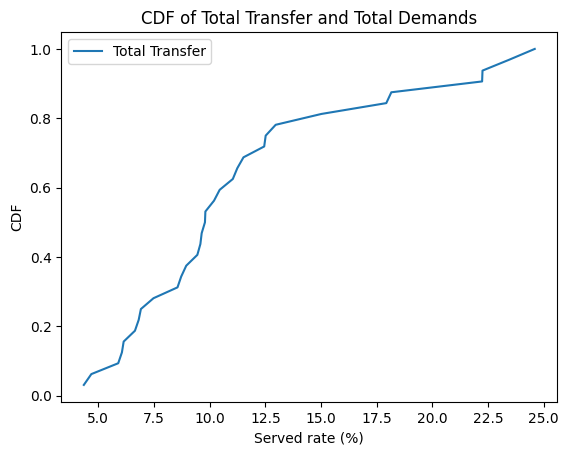

In [49]:
serve_rate_per_cell = total_transfer_per_cell / total_demands_per_cell * 100
# Calculate the CDF

sorted_serve_rate = np.sort(serve_rate_per_cell)
cdf = np.arange(1, len(sorted_serve_rate) + 1) / len(sorted_serve_rate)

# Plot the CDF
plt.plot(sorted_serve_rate, cdf, label='Total Transfer')
plt.xlabel('Served rate (%)')
plt.ylabel('CDF')
plt.legend()
plt.title('CDF of Total Transfer and Total Demands')
plt.show()

## number of hops

In [39]:
results_dir = '../results/gw_5_fix_demands/traceroute/'
file_list = os.listdir(results_dir)
traceroute_files = [file for file in file_list if file.startswith('traceroute_')]

total_hops = 0

avg_hops_per_cell = [0 for x in cell_indices]
success_links = [0 for x in cell_indices]

for file in traceroute_files:
    cell = int(file.split('_')[2])
    with open(results_dir + file, 'r') as f:
        traceroute_output = f.read()
    traceroute_lines = traceroute_output.split('\n')[:-1]
    hops = 0
    failed = 0
    if len(traceroute_lines) < 2:
        failed = 1
        continue

    for line in traceroute_lines[1:]:
        if '*' not in line or ('*' in line and '*' not in traceroute_lines[-1]):
            hops += 1
        elif '*' in line and '*' in traceroute_lines[-1]:
            failed = 1
            break
        
    if failed == 0:
        avg_hops_per_cell[cell_indices.index(cell)] += hops
        success_links[cell_indices.index(cell)] += 1
        
    if 2 <= len(traceroute_lines) < 3:
        print (file)

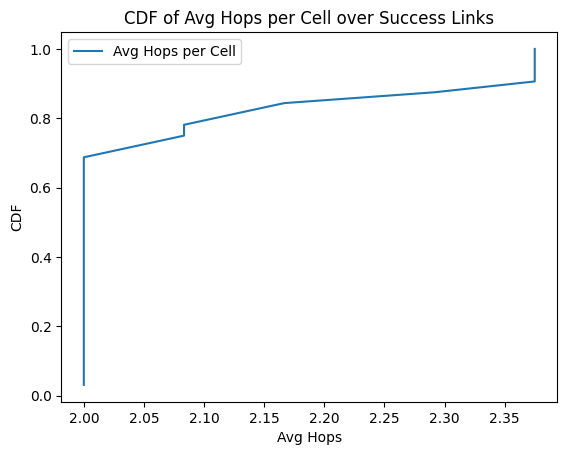

In [40]:
import numpy as np

import matplotlib.pyplot as plt

# Calculate the CDF
sorted_avg_hops = np.sort(avg_hops_per_cell/np.array(success_links))
cdf = np.arange(1, len(sorted_avg_hops) + 1) / len(sorted_avg_hops)

# Plot the CDF
plt.plot(sorted_avg_hops, cdf, label='Avg Hops per Cell')
plt.xlabel('Avg Hops')
plt.ylabel('CDF')
plt.legend()
plt.title('CDF of Avg Hops per Cell over Success Links')
plt.show()

## links load

In [64]:
import re

results_dir = '../results/gw_5_fix_demands/traceroute/'
file_list = os.listdir(results_dir)
traceroute_files = [file for file in file_list if file.startswith('traceroute_')]

trace_time = []

for file_name in traceroute_files:
    t = int(file_name.split('_')[1])
    if t not in trace_time:
        trace_time.append(t)
        
trace_time = sorted(trace_time)

total_hops = 0

sat_loads = [[0 for _ in range(200)] for _ in trace_time]
sat_links = [[0 for _ in range(200)] for _ in trace_time]


for file in traceroute_files:
    t = int(file.split('_')[1])
    cell_id = int(file.split('_')[2])
    with open(results_dir + file, 'r') as f:
        traceroute_output = f.read()
        
    traceroute_lines = traceroute_output.split('\n')[:-1]
    if len(traceroute_lines) < 2:
        continue
    
    ip_addresses = []
    for line in traceroute_lines[1:]:
        if '*' not in line:
            ip_address = re.findall(r'\(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\)', line)
        if ip_address:
            ip_addresses.append(ip_address[0].replace('(', '').replace(')', '').split('.'))
    
    for ip in ip_addresses:
        if ip[-1] != '10' and int(ip[-2]) < 200:
            sat_links[trace_time.index(t)][int(ip[-2])] += 1
            sat_loads[trace_time.index(t)][int(ip[-2])] += demands[cell_indices.index(cell_id)]
            
            
    sat_loads = np.array(sat_loads)
    sat_links = np.array(sat_links)

## Network delay

## Unconneted cell rate